# FULL NETWORK VISUALIZATION


Bundling edges:

1. **Decay**: The rate at which the influence of a node diminishes as distance from the node increases.
   1. node typically has a stronger influence on bundling edges that are closer to it, and this influence weakens with increasing distance.
   2. A steeper decay function will make the bundling more localized, focusing on grouping edges that originate or terminate at the same node or its immediate neighbors. Conversely, a shallower decay function will result in looser groupings where edges from farther away nodes can potentially contribute to the bundle.
   3. In short: Higher values of decay will result in more localized bundling, while lower values will result in more global bundling.
2. **Bandwidth**:
   1. Bandwidth refers to the maximum width allocated to a bundle of edges at any point in the visualization.
   2. It controls the visual thickness of the bundled edges. A higher bandwidth creates thicker bundles, making them more prominent in the visualization. A lower bandwidth results in thinner bundles, allowing for better distinction between multiple overlapping bundles.
   3. In short: Higher values of bandwidth will result in thicker bundles, while lower values will result in thinner bundles.

I want to focus on the global structure of the network, so the decay value will be low (maybe .1?) and the bandwidth will be high (maybe .7?).


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# remove the SettingWithCopyWarning
import networkx as nx
from datashader.bundling import hammer_bundle
import plotly.express as px
from forceatlas2 import forceatlas2_networkx_layout
from datashader.layout import random_layout, circular_layout, forceatlas2_layout

import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

pd.options.mode.chained_assignment = None

/opt/homebrew/Caskroom/miniconda/base/envs/Study1Analysis/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pg = "../data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
G = nx.read_graphml(pg)
pdf = "../data/06-clustered-df/alpha0.3_k10_res0.002.pkl"
df = pd.read_pickle(pdf)

pcd = "../output/tables/cluster-explorer/SingleSolExplorer_alpha0.3_k10_res0.002.xlsx"
# first sheet is the cluster details
cluster_details = pd.read_excel(pcd, sheet_name=0)

In [3]:
import pandas as pd


def graph_to_dataframes(G):
    # Nodes DataFrame
    nodes_data = [
        (node, data.get("cluster"), data.get("centrality_alpha0.3_k10_res0.002"))
        for node, data in G.nodes(data=True)
    ]
    nodes_df = pd.DataFrame(nodes_data, columns=["name", "cluster", "centrality"])
    nodes_df["cluster"] = nodes_df["cluster"].astype(int).astype("category")
    nodes_df["centrality"] = nodes_df["centrality"].astype(float)
    # drop centrality
    # nodes_df.drop(columns=["centrality"], inplace=True)
    nodes_df.index = [x.replace("n", "") for x in nodes_df["name"]]

    # Edges DataFrame
    edges_data = [
        (source, target, data.get("weight"))
        for source, target, data in G.edges(data=True)
    ]
    edges_df = pd.DataFrame(edges_data, columns=["source", "target", "weight"])
    edges_df["weight"] = edges_df["weight"].astype(float)
    edges_df["source"] = [x.replace("n", "") for x in edges_df["source"]]
    edges_df["target"] = [x.replace("n", "") for x in edges_df["target"]]
    # drop weight
    # edges_df.drop(columns=["weight"], inplace=True)

    print(f"Nodes DataFrame: {nodes_df.shape}")
    print(f"Edges DataFrame: {edges_df.shape}")

    return nodes_df, edges_df

In [4]:
import pandas as pd

# use a subgraph of the cluster 1-10
clusters_to_keep = list(range(10, 30))
G = G.subgraph([n for n, d in G.nodes(data=True) if d["cluster"] in clusters_to_keep])

nodes_df, edges_df = graph_to_dataframes(G)
print("Nodes DataFrame:")
print(nodes_df.head(3))
print("\nEdges DataFrame:")
print(edges_df.head(3))

Nodes DataFrame: (9748, 3)
Edges DataFrame: (106956, 3)
Nodes DataFrame:
         name cluster  centrality
27873  n27873      16    0.339152
29584  n29584      10    0.067927
22376  n22376      11    0.472778

Edges DataFrame:
  source target    weight
0  27873   4854  0.300000
1  27873   7383  0.650039
2  27873   8076  0.300000


In [5]:
forcedirected = forceatlas2_layout(nodes_df, edges_df)

In [6]:
import datashader.transfer_functions as tf


def nodesplot(
    nodes, name=None, canvas=None, cat="cluster", cmap=["#FF3333", "#33FF33", "#3333FF"]
):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator = None if cat is None else ds.count_cat(cat)
    agg = canvas.points(nodes, "x", "y", aggregator)
    return tf.spread(tf.shade(agg, cmap=cmap), px=3, name=name)


# Example usage with a valid colormap
tf.Images(
    nodesplot(
        forcedirected, "ForceAtlas2 layout", cmap=["#FF3333", "#33FF33", "#3333FF"]
    )
)

NameError: name 'cvsopts' is not defined

In [ ]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, "x", "y", agg=ds.count()), name=name)


def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)

    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


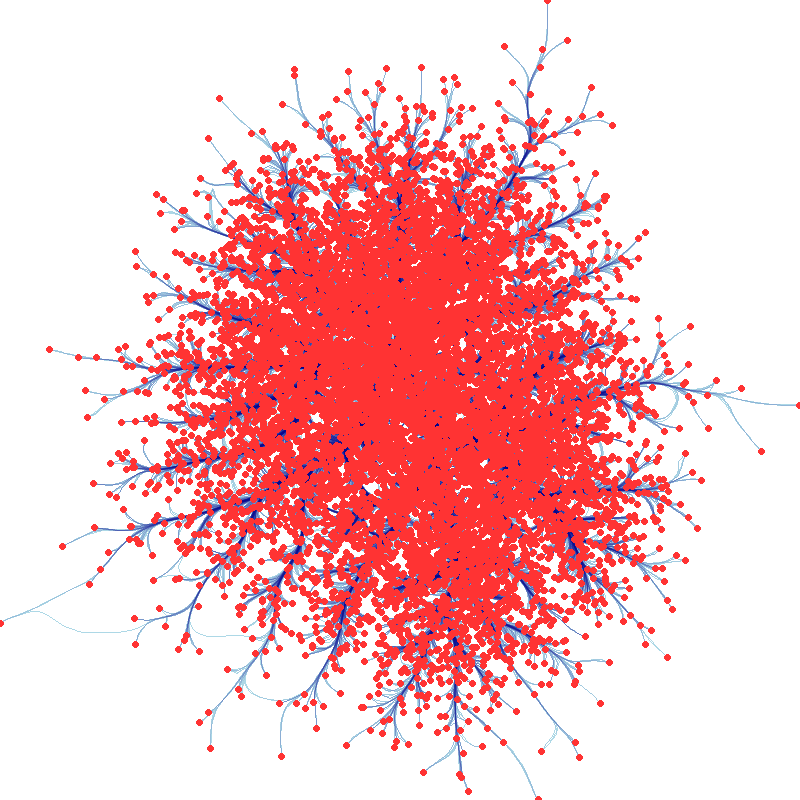

In [ ]:
fd = forcedirected.copy()

fd_b = graphplot(fd, hammer_bundle(fd, edges), "Force-directed, bundled")

tf.Images(fd_b)

higher initial bandwidth and higher decay time constants leading to larger-scale bundling



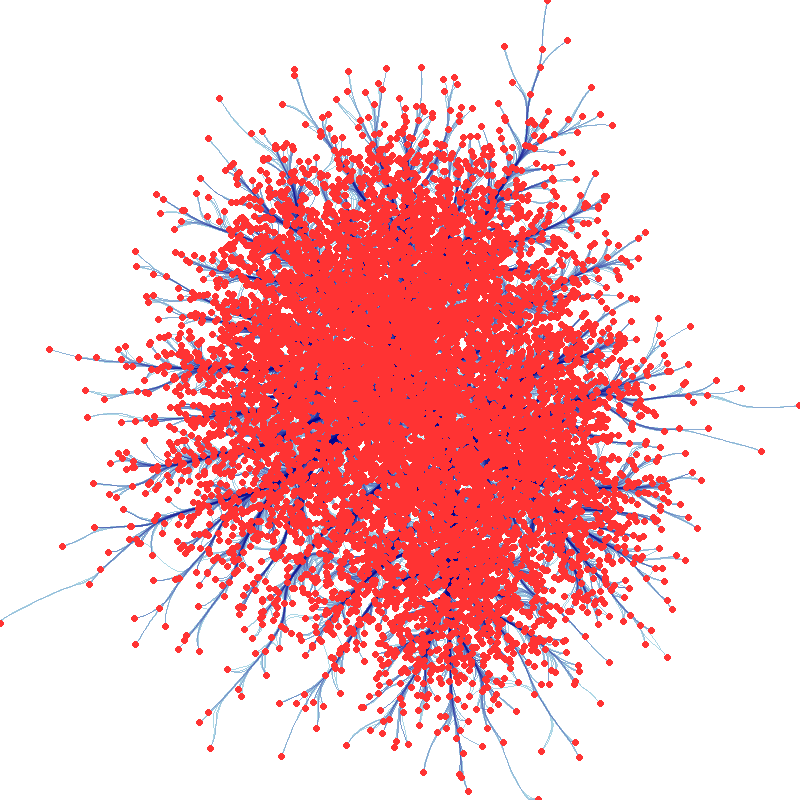

In [ ]:
# we can specify decay and bandwidth parameters
fd_b = graphplot(
    fd,
    hammer_bundle(fd, edges, iterations=10, decay=0.3, initial_bandwidth=0.3),
    "Force-directed, bundled",
)

tf.Images(fd_b)

In [ ]:
grid = [
    graphplot(
        fd,
        hammer_bundle(fd, edges, iterations=5, decay=decay, initial_bandwidth=bw),
        "d={:0.2f}, bw={:0.2f}".format(decay, bw),
    )
    for decay in [0.1, 0.25, 0.5, 0.9]
    for bw in [0.1, 0.2, 0.5, 1]
]


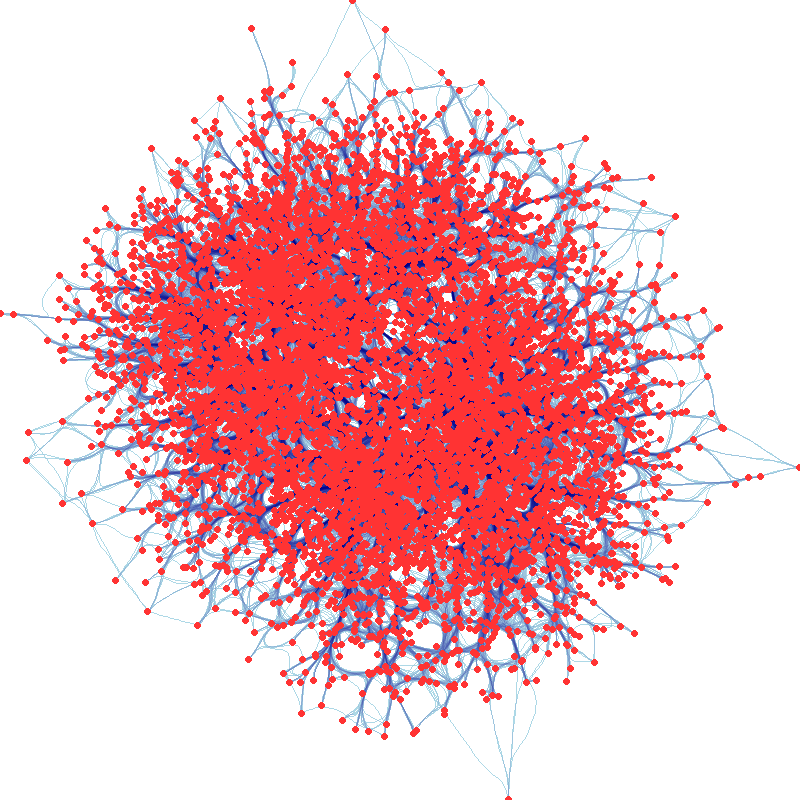
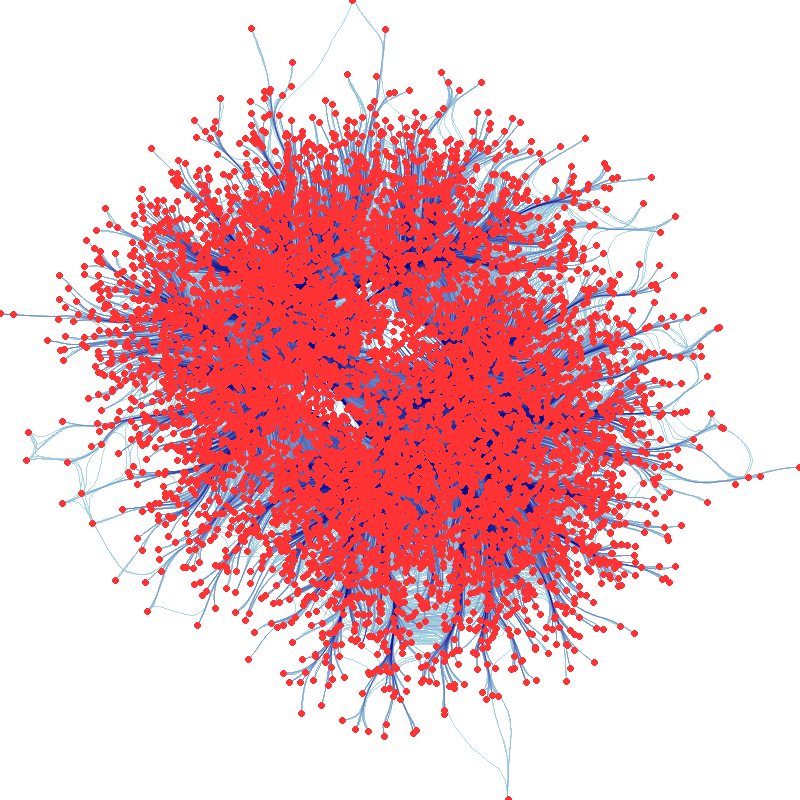
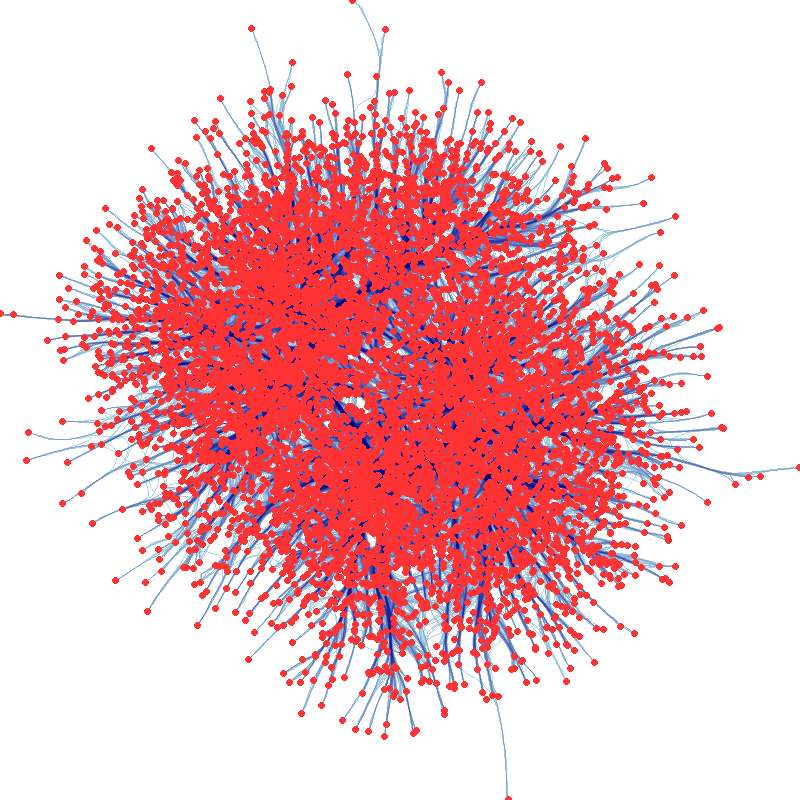
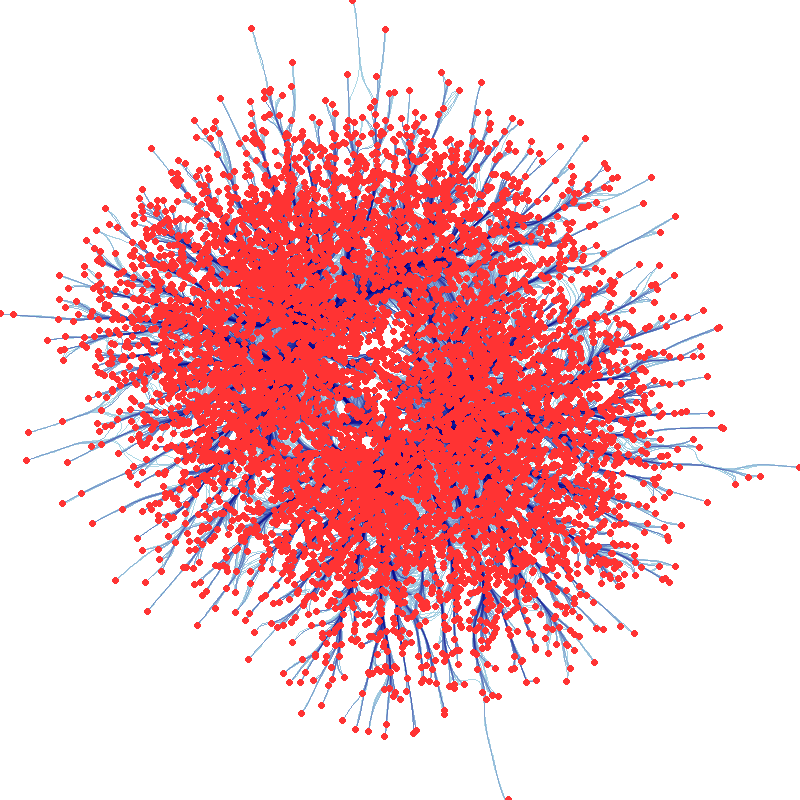
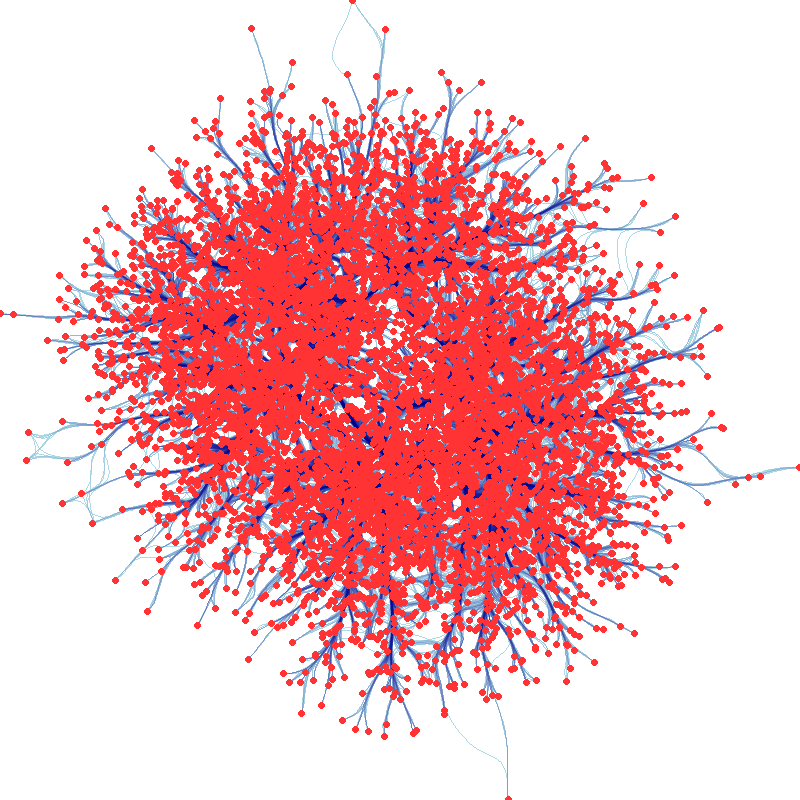
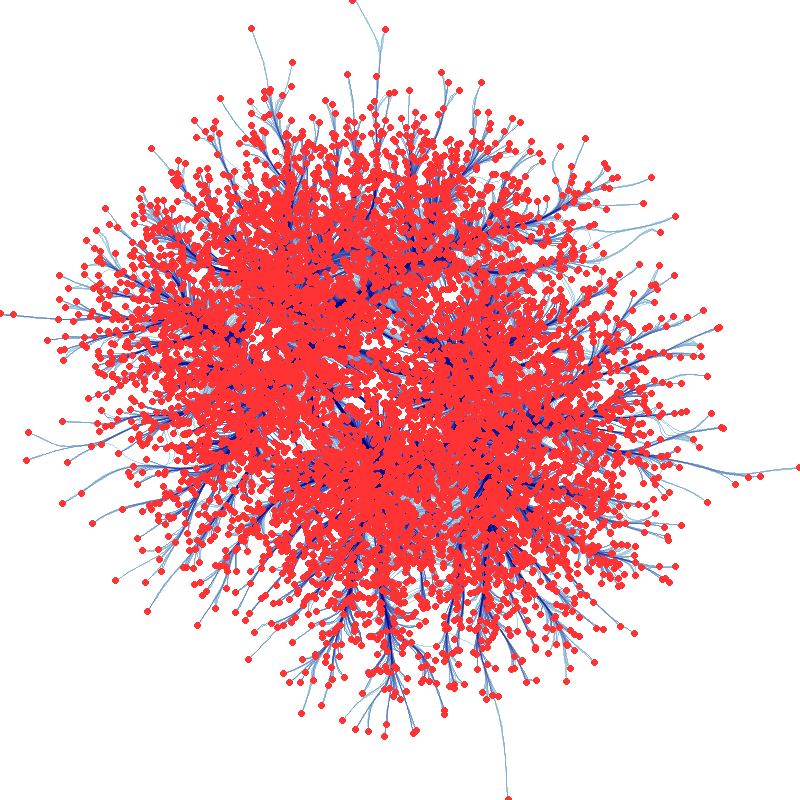
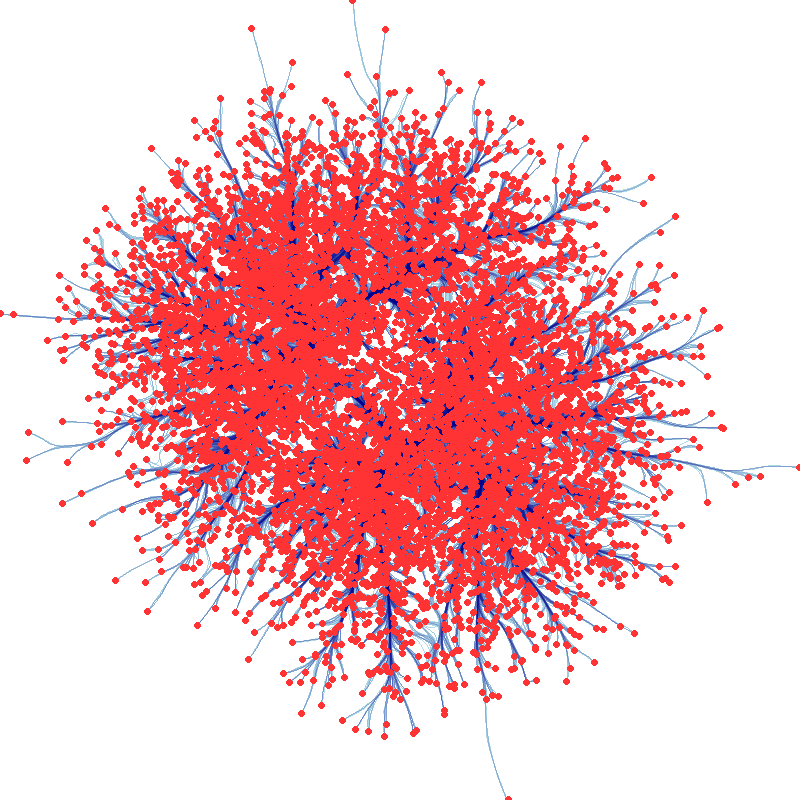
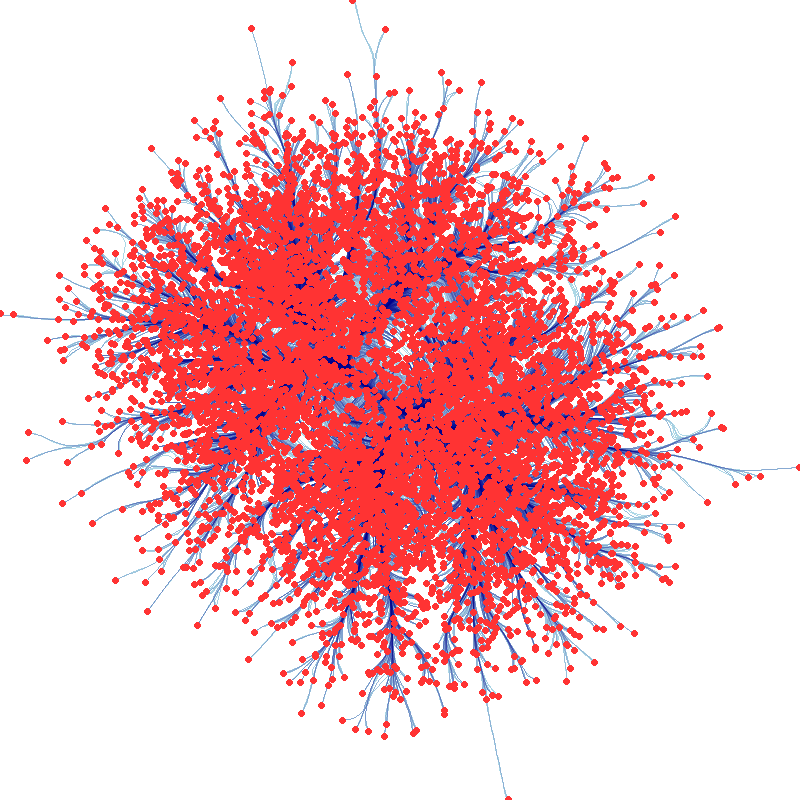
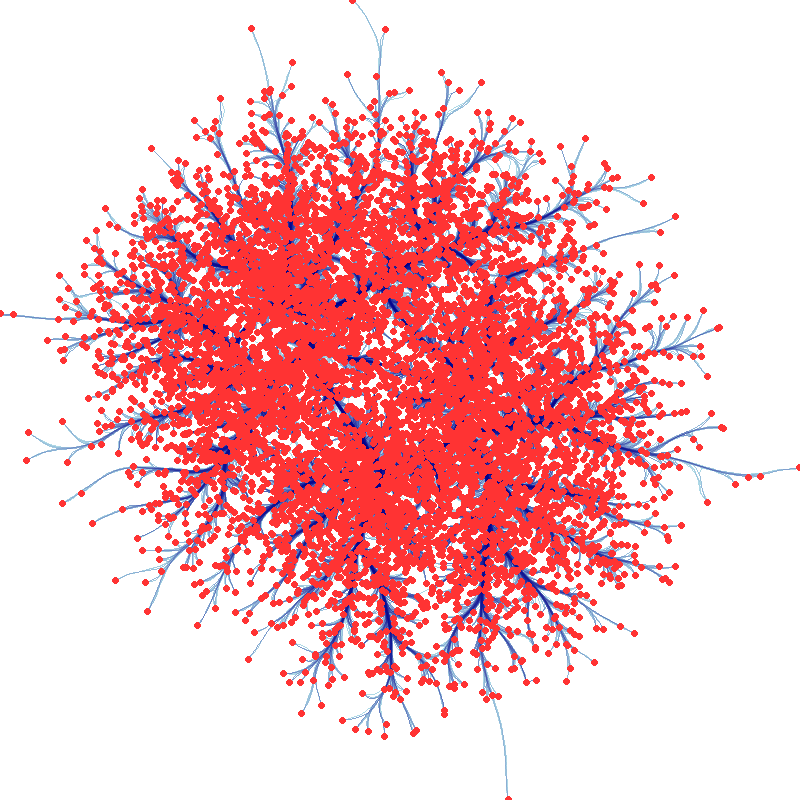
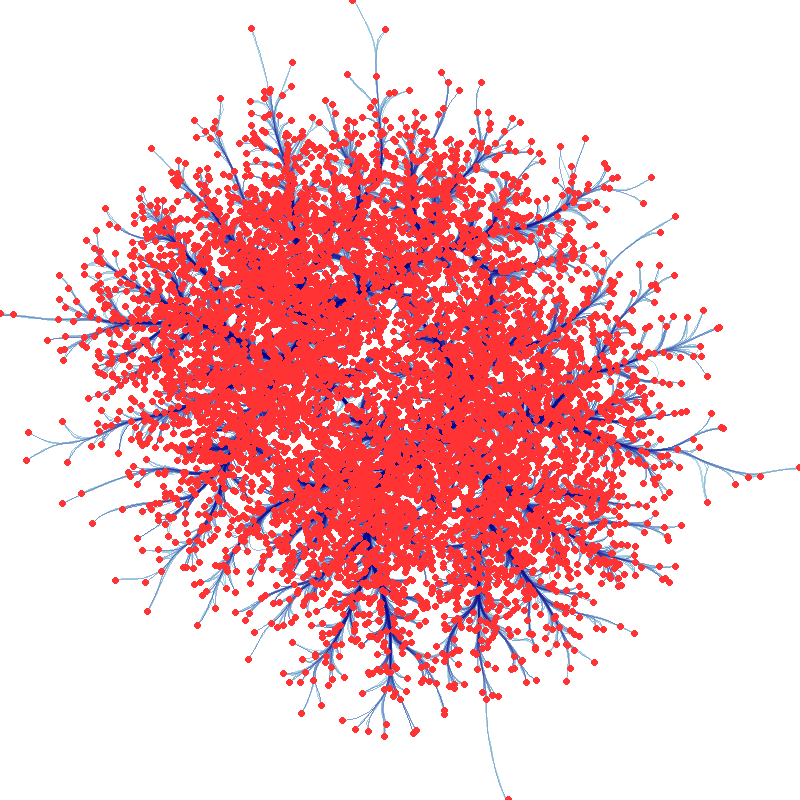
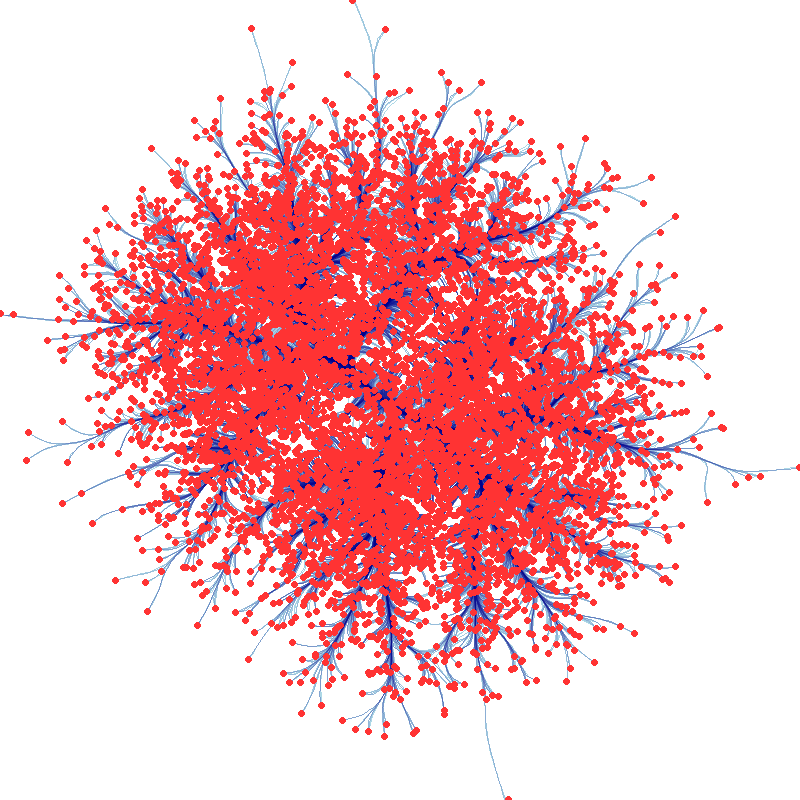
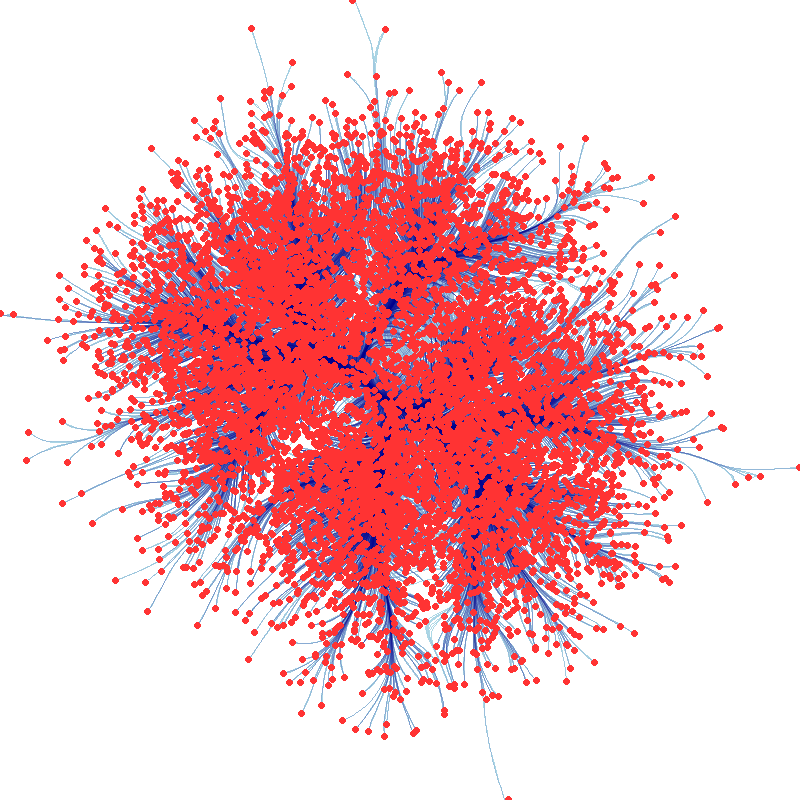
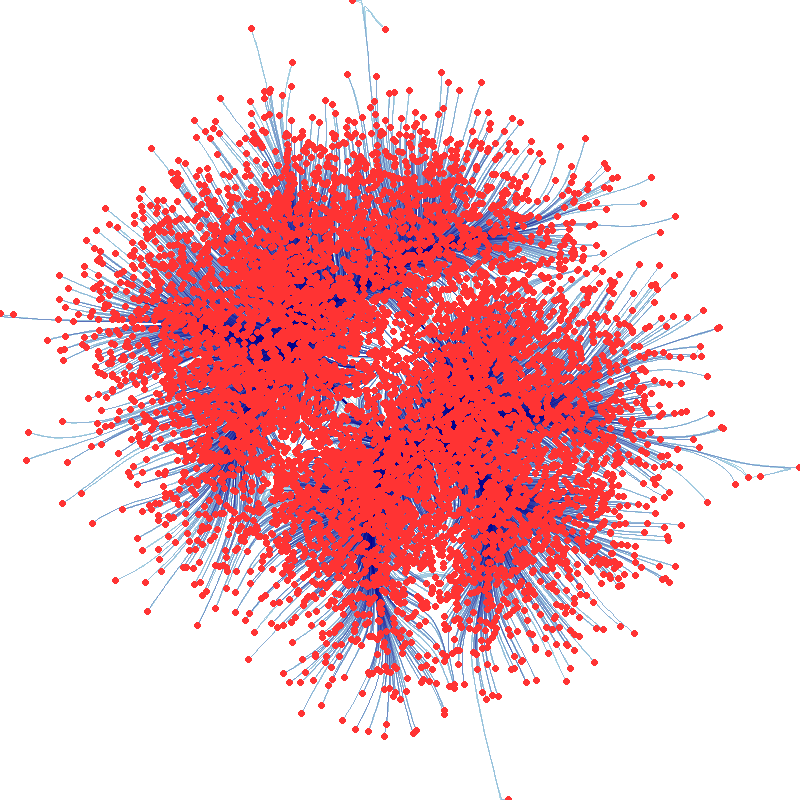
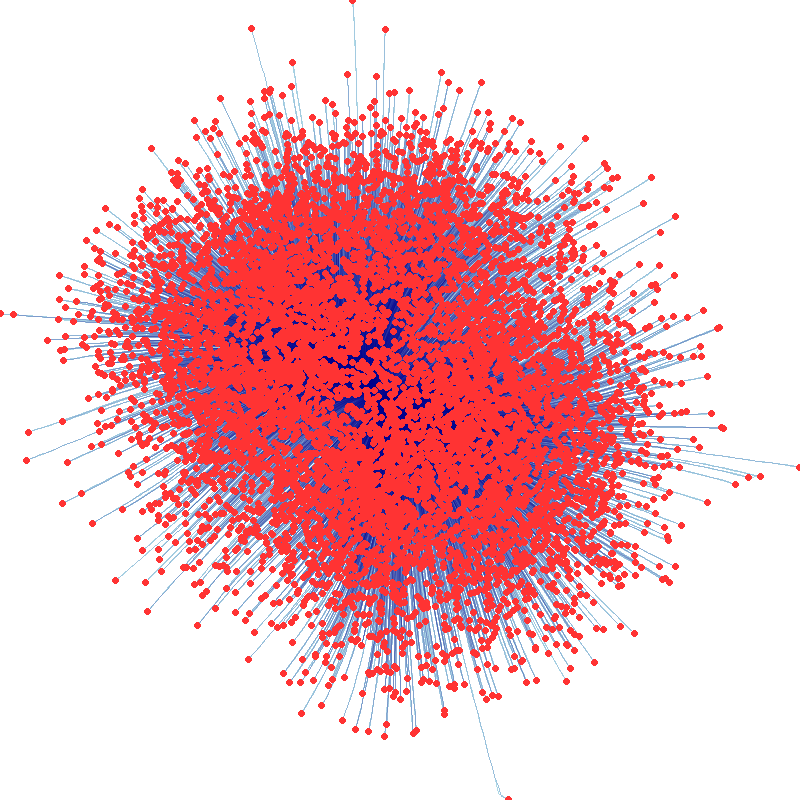
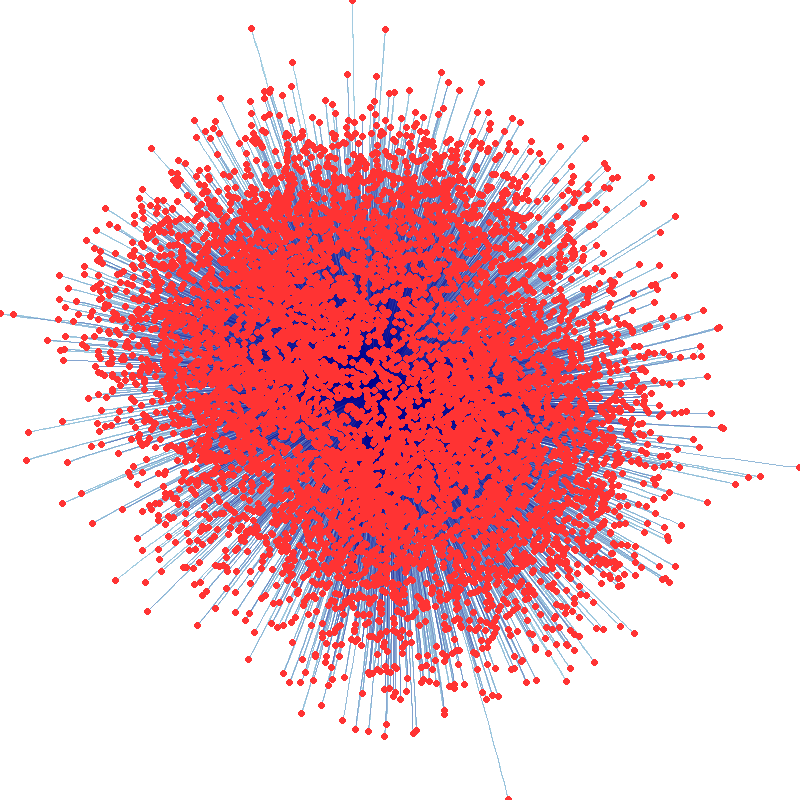
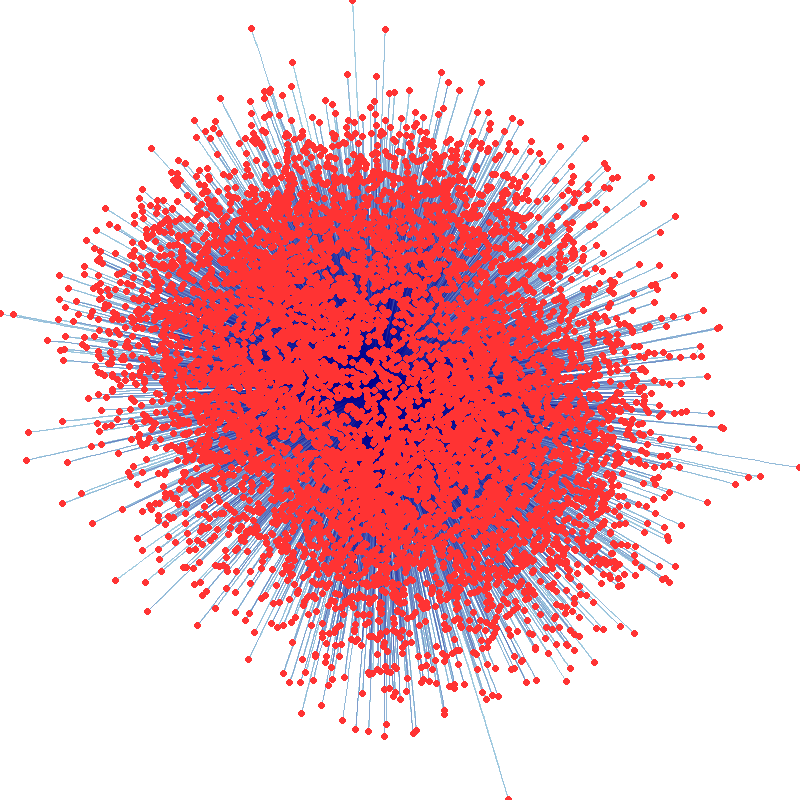

In [ ]:
tf.Images(*grid).cols(4)

# with clusters


In [ ]:
def datashader_prep(nodes_df, edges_df):
    # nodes_df.drop(columns=["centrality"], inplace=True)
    nodes_df.index = [x.replace("n", "") for x in nodes_df["node"]]
    # rename to name
    nodes_df.rename(columns={"node": "name"}, inplace=True)

    # edges_df
    edges_df["source"] = [x.replace("n", "") for x in edges_df["source"]]
    edges_df["target"] = [x.replace("n", "") for x in edges_df["target"]]
    # drop weight
    edges_df.drop(columns=["weight"], inplace=True)
    return nodes_df, edges_df


cnodes, cedges = datashader_prep(nodes_df, edges_df)

KeyError: 'node'

In [ ]:
nodes_df["cluster"].unique()

/opt/homebrew/Caskroom/miniconda/base/envs/Study1Analysis/lib/python3.11/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[55.0, 14.0, 38.0, 99.0, 12.0, ..., 130.0, 141.0, 136.0, 148.0, 133.0]
Length: 147
Categories (147, float64): [0.0, 1.0, 2.0, 3.0, ..., 144.0, 148.0, 150.0, 151.0]

In [ ]:
edges_df

source  target
0   n24771  n15082
1   n27038  n20718
2    n9728  n34265
3   n27659  n22201
4   n23953   n5968
..     ...     ...
90  n16155  n16651
91  n33487  n32921
92  n12081  n38544
93  n10243   n7394
94  n17421  n19473

[95 rows x 2 columns]

In [ ]:
fd = forceatlas2_layout(nodes_df, edges_df)

In [ ]:
fd_b = graphplot(
    fd,
    hammer_bundle(fd, edges_df, decay=0.5, initial_bandwidth=0.5),
    "Force-directed, bundled",
    cat="cluster",
)


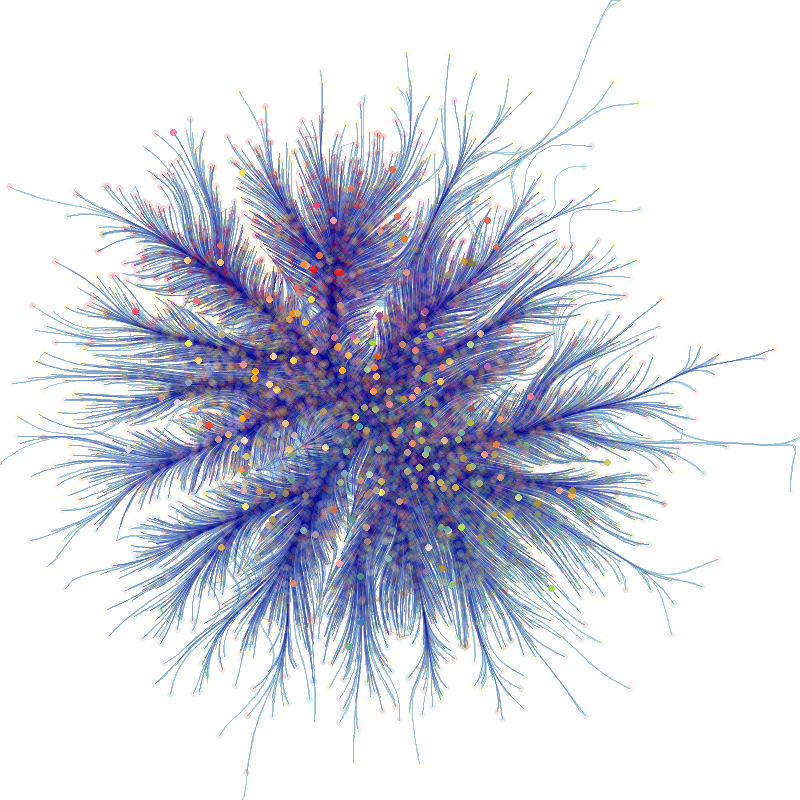

In [ ]:
tf.Images(fd_b)